# CoOptimal Transport

This notebook will review optimal transport, introduce co-optimal transport, and make connections to Gromov-Wasserstein optimal transport.

In [1]:
from IPython.display import Latex

# References

This notebook will introduce co-optimal transport from Redko et al (https://arxiv.org/pdf/2002.03731.pdf).

For a full tutorial on computational optimal transport, see Computational Optimal Transport by Peyre et al (https://www.nowpublishers.com/article/Details/MAL-073).

# Background on Optimal Transport

Optimal transport finds the most cost-effective way to move data points from one domain to another. One way to think about optimal transport is as the problem of moving a pile of sand to fill in a hole through the least amount of work.

The Kantorovich optimal transport problem seeks to find a minimal cost mapping between two probability distributions. Referring back to the problem of moving a sand pile to fill in a hole, Kantorovich optimal transport allows us to split the mass of a grain of sand instead of moving the whole grain. 

Without loss of generality, I will present discrete optimal transport for two datasets. Let the two sets of points be $X = (x_1, x_2, \dots, x_{n})$ from $\mathcal{X}$ and $Y = (y_1, y_2, \dots, y_{m})$ from $\mathcal{Y}$. The datasets have $n$ and $m$ points, respectively. 

We assume the data follow discrete distributions $p$ on $\mathcal{X}$ and $q$ on $\mathcal{Y}$, which we can write as
\begin{equation*}
    p = \sum_{i=1}^{n_x} p_i \delta_{x_i} \text{ and } q = \sum_{j=1}^{n_y} q_j \delta_{y_j}.
\end{equation*}
where $\delta_{x_i}$ is the Dirac measure. 

Optimal transport seeks a coupling matrix from the set
\begin{equation}
    \Pi(p,q) = \{ \Gamma \in \mathbb{R}_+^{n_x \times n_y} : \Gamma 1_{n_y} = p, \ \Gamma^T 1_{n_x} = q \}. 
\end{equation}
Each entry $\Gamma_{ij}$ in the coupling matrix gives a probability of how likely it is that data point $x_i$ in $\mathcal{X}$ is related to data point $y_j$ in $\mathcal{Y}$. 


We're not just looking for any coupling matrix; we're looking for the most cost effective matrix to relate $p$ and $q$. This means that we need to define some cost matrix $C$ to capture the cost of moving the points between the two spaces. In particular, $C_{ij}$ captures the cost of moving data point $x_i$ to data point $y_j$. 

Intuitively, the cost function says how many resources it will take to move $x$ to $y$, and the coupling $\pi$ assigns a probability that $x$ should be moved to $y$ for each $x$ and $y$ in the two spaces. A discrete coupling $\Gamma$ relates two measures $p$ and $q$ in a meaningful way: Each row $\Gamma_i$ tells us how to split the mass of data point $x_i$ onto the points $y_j$ for $j =1, \dots, n_y$, and the condition $\Gamma 1_{n_{y}} = p$ requires that the sum of each row $\Gamma_i$ is equal to the probability of sample $x_i$. 

The discrete optimal transport problem attempts to find a coupling that minimizes the cost of moving samples through the linear program:
\begin{equation}
    \min_{\Gamma \in \Pi(p,q)} \sum_{i=1}^n \sum_{j=1}^m C_{ij} \Gamma_{ij}.
\end{equation}

Note that when the spaces of interest are both the same metric space with set $\mathcal{M}$, distance $d$, and cost function $c(x,y) = d(x,y)^p$, then the optimal transport distance is equivalent to the $p-$th Wasserstein distance:
\begin{equation}
    W^p(\mu, \nu) =  \left( \inf_{\pi \in \Pi(\mu, \nu)} \int_{\mathcal{M} \times \mathcal{M}} d(x,y)^p d\pi(x,y) \right)^{\frac{1}{p}}. 
\end{equation}
Wasserstein distances measure the distances between probability distributions on a metric space and are commonly used in machine learning applications. 


Although this problem can be solved with minimum cost flow solvers, it is usually regularized with entropy for more efficient optimization and empirically better results \cite{cuturi2013sinkhorn}. The addition of entropy diffuses the optimal coupling, meaning that more masses will be split. Thus, the optimal transport problem that is solved numerically is
\begin{equation}
    \min_{\Gamma \in \Pi(p,q)} \sum_{i=1}^n \sum_{j=1}^m C_{ij} \Gamma_{ij} - \epsilon H(\Gamma),
    \label{entropicOT}
\end{equation}
where $\epsilon > 0$ and $H(\Gamma)$ is the entropy defined by
\begin{equation}
    H(\Gamma) = \sum_{i=1}^{n_x} \sum_{j=1}^{n_y} \Gamma_{ij} \log \Gamma_{ij}.
\end{equation}

# Install needed packages

Note: To run this, you'll need to first install matplotlib, cython, and POT

In [2]:
pip install numpy scipy scikit-learn cython matplotlib POT

You should consider upgrading via the '/home/rebecca/Documents/ManifoldAlignment/Example/venv/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import matplotlib.pylab as pl
from mpl_toolkits.mplot3d import Axes3D  # noq
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss
import random
import scipy as sp
from sklearn.metrics import pairwise_distances

# Example 1

This first example will compute the optimal transport between two distributions (that do not depend on data).

In [4]:
#%% parameters

n = 100  # nb bins

# bin positions
x = np.arange(n, dtype=np.float64)

# Gaussian distributions
a = gauss(n, m=20, s=5)  # m= mean, s= std
b = gauss(n, m=60, s=10)

# loss matrix
M = ot.dist(x.reshape((n, 1)), x.reshape((n, 1)))
M /= M.max()

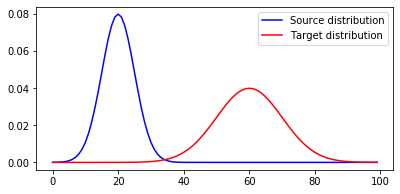

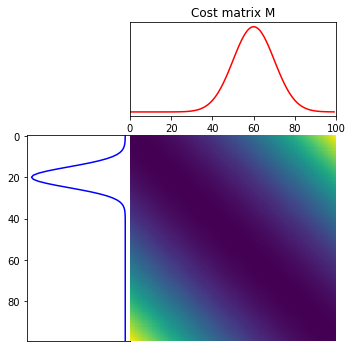

In [5]:
#%% plot the distributions

pl.figure(1, figsize=(6.4, 3))
pl.plot(x, a, 'b', label='Source distribution')
pl.plot(x, b, 'r', label='Target distribution')
pl.legend()

#%% plot distributions and loss matrix

pl.figure(2, figsize=(5, 5))
ot.plot.plot1D_mat(a, b, M, 'Cost matrix M')


It.  |Err         
-------------------
    0|2.861463e-01|
   10|1.860154e-01|
   20|8.144529e-02|
   30|3.130143e-02|
   40|1.178815e-02|
   50|4.426078e-03|
   60|1.661047e-03|
   70|6.233110e-04|
   80|2.338932e-04|
   90|8.776627e-05|
  100|3.293340e-05|
  110|1.235791e-05|
  120|4.637176e-06|
  130|1.740051e-06|
  140|6.529356e-07|
  150|2.450071e-07|
  160|9.193632e-08|
  170|3.449812e-08|
  180|1.294505e-08|
  190|4.857493e-09|
It.  |Err         
-------------------
  200|1.822723e-09|
  210|6.839572e-10|


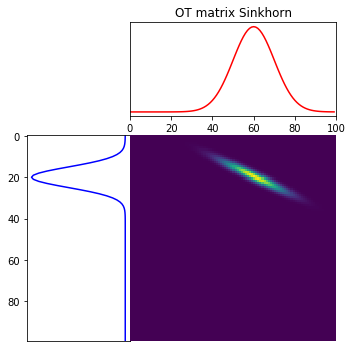

In [6]:
#%% Sinkhorn iterations to compute the optimal transport

lambd = 1e-3
Gs = ot.sinkhorn(a, b, M, lambd, verbose=True)

pl.figure(4, figsize=(5, 5))
ot.plot.plot1D_mat(a, b, Gs, 'OT matrix Sinkhorn')

pl.show()

# Example 2

This second example will show how to compute the optimal transport for distributions from data. One data set will be a rotation of the other with some noise.

In [7]:
n = 100  # nb samples
m = n

R = np.array([[0, -1],[1, 0]]) # rotation matrix

x = np.zeros((n, 2))
for i in range(n):
    x[i,0] = i
    x[i,1] = .1*i*np.sin(i)
z = np.random.uniform(-.1, .1, (m,1)) # rotate x to make y and add noise
y = np.matmul(x,R) + z

p, q = np.ones((n,)) / n, np.ones((m,)) / m  # uniform distribution on samples

# loss matrix
M2 = ot.dist(x, y)
M2 /= M2.max()

Text(0.5, 1.0, 'Cost matrix M')

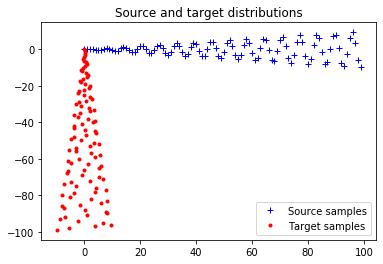

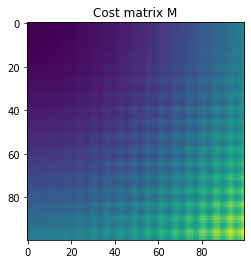

In [8]:
#%% plot samples

pl.figure(1)
pl.plot(x[:, 0], x[:, 1], '+b', label='Source samples')
pl.plot(y[:, 0], y[:, 1], '.r', label='Target samples')
pl.legend(loc=0)
pl.title('Source and target distributions')

pl.figure(2)
pl.imshow(M2, interpolation='nearest')
pl.title('Cost matrix M')

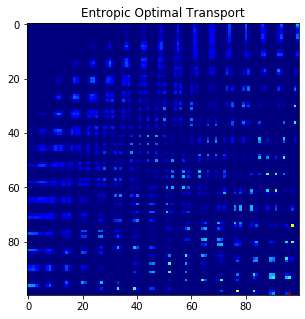

In [9]:
#%% sinkhorn iterations

# reg term
lambd = 1e-3

Gd = ot.sinkhorn(p, q, M2, lambd, verbose=False)

# plot the coupling matrix
pl.figure(1, (10, 5))
pl.imshow(Gd, cmap='jet')
pl.title('Entropic Optimal Transport')

pl.show()

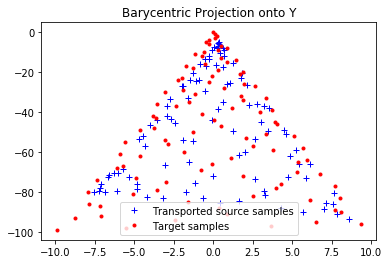

In [10]:
# perform the transport
x_transport = np.matmul(Gd, y)*n

pl.figure(7)
pl.plot(x_transport[:,0], x_transport[:,1], '+b', label='Transported source samples')
pl.plot(y[:, 0], y[:, 1], '.r', label='Target samples')
pl.legend(loc=0)
pl.title('Barycentric Projection onto Y')

pl.show()

In [11]:
# create a function to measure how good the alignment is
def calc_frac_idx(x, y, n):
    fracs = []
    rank=0
    all_dists = pairwise_distances(x, y, metric='euclidean')
    for row_idx in range(n):
        euc_dist = all_dists[row_idx, :]
        true_nbr = euc_dist[row_idx]
        sort_euc_dist = sorted(euc_dist)
        rank =sort_euc_dist.index(true_nbr)
        frac = float(rank)/(n -1)

        fracs.append(frac)

    return fracs

def avg_frac_idx(x,y,n):
    fracs1 = calc_frac_idx(x,y,n)
    fracs2 = calc_frac_idx(y,x, n)
    return(np.mean(np.add(fracs1,fracs2)/2))

In [12]:
print("The average fraction of points closer than the true neighbor is ", avg_frac_idx(x_transport,y,n))

The average fraction of points closer than the true neighbor is  0.5275252525252525


# CO-Optimal Transport

CO-optimal transport attempts to simultaneously learn couplings between the features and between the samples. Given the same setup as before, we now assume that our samples come from domains with feature dimensions $d_x$ and $d_y$, respectively. Then, we also define marginal distrbutions on the feature spaces, call them $v$ and $w$. Introduce a divergence measure $L: \mathbb{R} \times \mathbb{R} \to \mathbb{R}$. Then, the CO-optimal problem is:
\begin{equation}
    \min_{\Gamma^s \in \Pi(p,q), \Gamma^f \in \Pi(v,w)} \sum_{i=1}^{n_x} \sum_{j=1}^{n_y} \sum_{k=1}^{d_x} \sum_{l =1}^{d_y} L(X_{ik}, Y_{jl}) \Gamma^s_{ij} \Gamma^f_{kl}
\end{equation}
Note that this problem seeks a coupling $\Gamma^s$ between the samples while simultaneously finding a coupling $\Gamma^f$ between the features. 

Like optimal transport, CO-optimal transport uses entropic regularization for computational efficiency. Instead of using the entropy of the coupling matrix though, CO-optimal transport looks at the relative entropy:
\begin{equation}
    H(\Gamma | p, q) = \sum_{i=1}^{n_x} \sum_{j=1}^{n_y} \Gamma_{ij} \log \left( \frac{\Gamma_{ij}}{ p_i q_j} \right)
\end{equation}

Thus, the term that is added to the CO-OT problem is
\begin{equation}
    \epsilon_1 H(\Gamma^s | p,q) + \epsilon_2 H(\Gamma^f | v,w),
\end{equation}
which means that the regularized CO-OT optimization problem is:
\begin{equation}
    \min_{\Gamma^s \in \Pi(p,q),  \ \Gamma^f \in \Pi(v,w)}  \sum_{i=1}^{n_x} \sum_{j=1}^{n_y} \sum_{k=1}^{d_x} \sum_{l =1}^{d_y} L(X_{ik}, Y_{jl}) \Gamma^s_{ij} \Gamma^f_{kl} + \epsilon_1 H(\Gamma^s | p,q) + \epsilon_2 H(\Gamma^f | v,w)
\end{equation}
The relative entropy has the same impact as regular entropy does on OT: it leads to more robust estimation but at the cost of less sparse solutions.

For co-clustering, they change the problem to have $X \in \mathbb{R}^{n \times d}$ and a matrix of cluster centroids $X^C$:
 \begin{equation}
    \min_{\Gamma^s \in \Pi(p,q), \  \Gamma^f \in \Pi(v,w), \ X^C \in \mathbb{R}^{g \times m}} \sum_{i=1}^{n} \sum_{j=1}^{g} \sum_{k=1}^{d} \sum_{l =1}^{m} L(X_{ik}, X^c_{jl}) \Gamma^s_{ij} \Gamma^f_{kl}
\end{equation}

# Gromov-Wasserstein Optimal Transport

Classic optimal transport requires defining a cost function across domains, which can be difficult to implement when the domains are in different dimensions. Gromov-Wasserstein distance extends optimal transport by comparing distances between samples rather than directly comparing the samples themselves. For this extension we need to assume we have metric measure spaces $(\mathcal{X}, d_x, \mu)$ and $(\mathcal{Y}, d_y, \nu)$, where $d_x$ and $d_y$ are distances on $\mathcal{X}$ and $\mathcal{Y}$, respectively. Instead of defining a cost function between spaces as in classic optimal transport, Gromov-Wasserstein uses the difference between pairwise distances.

For the discrete case, we can compute pairwise distance matrices $D^x$ and $D^y$ as well as the fourth order tensor $\mathbf{L} \in \mathbb{R}^{n_x \times n_x \times n_y \times n_y}$, where $\mathbf{L}_{ijkl} = L(D^x_{ik}, D^y_{jl})$ measures the distance between pairwise distances in the two domains. The main change from basic optimal transport to Gromov-Wasserstein is that we consider the effect of transporting pairs of points rather than single points. Intuitively, $L(d_x(x_1, x_2),$ $d_y(y_1, y_2))$ now captures how transporting $x_1$ onto $y_1$ and $x_2$ onto $y_2$ would distort the original distances between $x_1$ and $x_2$ and between $y_1$ and $y_2$.

The discrete Gromov-Wasserstein problem is then defined by
\begin{equation}
    GW(p,q) = \min_{\Gamma \in \Pi(p,q)} \sum_{i,j,k,l} \mathbf{L}_{ijkl} \Gamma_{ij} \Gamma_{kl}. 
    \label{discreteGW}
\end{equation}
For each tuple $(x_i, x_k, y_j, y_l)$, we are computing the cost of altering the pairwise distances between $x_i$ and $x_k$ when splitting their masses to $y_j$ and $y_l$ by weighting them by $\Gamma_{ij}$ and $\Gamma_{kl},$ respectively. 

As in the classical optimal transport case, the coupling matrix can then be efficiently computed for an entropically regularized optimization problem:
\begin{equation}
    GW(p,q) = \min_{\Gamma \in \Pi(p,q)} \ \langle \mathbf{L}(D^x, D^y) \otimes \Gamma, \Gamma \rangle  - \epsilon H(\Gamma). 
\end{equation}
Larger values of $\epsilon$ lead to an easier optimization problem but also lead to a denser coupling matrix, meaning that more data points exhibit significant correspondences with one another. Smaller values of $\epsilon$ lead to sparser solutions, meaning that the coupling matrix is more likely to find the correct one-to-one correspondences for datasets where there are one-to-one correspondences. However, it also yields a harder (more non-convex) optimization problem . 

# Connection between CO-OT and GW

\begin{equation}
    \min_{\Gamma \in \Pi(p,q)} \sum_{i=1}^{n_x} \sum_{j=1}^{n_y} \sum_{k=1}^{n_x} \sum_{l=1}^{n_y} \mathbf{L}(D^x_{ik}, D^y_{jl}) \Gamma_{ij} \Gamma_{kl}
\end{equation}

# Example 3

This third example will show how Gromov-Wasserstein performs when the data are in different spaces. 

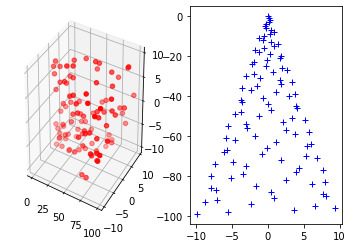

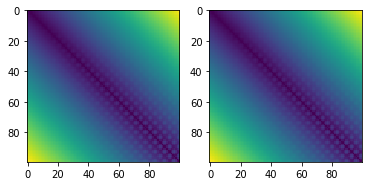

In [13]:
# add a third dimension to the x data
dim3 = np.random.uniform(low = -10, high = 10, size = (n,1))
x3 = np.append(x, dim3, 1)

# plot the new data
fig = pl.figure()
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x3[:, 0], x3[:, 1], x3[:, 2], color='r')
ax2 = fig.add_subplot(122)
ax2.plot(y[:, 0], y[:, 1], '+b', label='Source samples')
pl.show()

# compute the distances within each data set
C1 = sp.spatial.distance.cdist(x, x)
C2 = sp.spatial.distance.cdist(y, y)

C1 /= C1.max()
C2 /= C2.max()

pl.figure()
pl.subplot(121)
pl.imshow(C1)
pl.subplot(122)
pl.imshow(C2)
pl.show()



Entropic Gromov-Wasserstein distances: 0.0006133279396962604


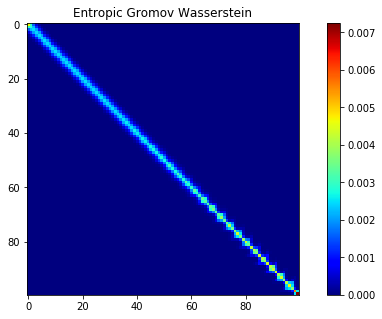

In [14]:
# sinkhorn iterations
gw, log = ot.gromov.entropic_gromov_wasserstein(
    C1, C2, p, q, 'square_loss', epsilon=10**-3, log=True, verbose=False)

print('Entropic Gromov-Wasserstein distances: ' + str(log['gw_dist']))

# plot the coupling matrix
pl.figure(1, (10, 5))
pl.imshow(gw, cmap='jet')
pl.title('Entropic Gromov Wasserstein')
pl.colorbar()
pl.show()

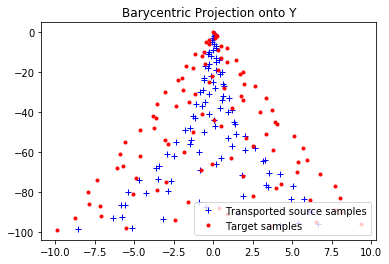

In [15]:
# perform the transport
x_transport2 = np.matmul(gw, y)*n

pl.figure(7)
pl.plot(x_transport2[:,0], x_transport2[:,1], '+b', label='Transported source samples')
pl.plot(y[:, 0], y[:, 1], '.r', label='Target samples')
pl.legend(loc=0)
pl.title('Barycentric Projection onto Y')


pl.show()

In [16]:
print("The average fraction of points closer than the true neighbor is ", avg_frac_idx(x_transport2,y,n))

The average fraction of points closer than the true neighbor is  0.0038888888888888888
